# Remapping a scalar quantity from a curvinilear to rectilinear grid

In [123]:
import numpy
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [112]:
%matplotlib inline

In [113]:
thetao_file = '/Users/irv033/Downloads/data/thetao_Omon_NorESM1-M_historical_r1i1p1_1850.nc'
tas_file = '/Users/irv033/Downloads/data/tas_Amon_NorESM1-M_historical_r1i1p1_1850.nc'
areacella_file = '/Users/irv033/Downloads/data/areacella_fx_NorESM1-M_historical_r0i0p0.nc'
areacello_file = '/Users/irv033/Downloads/data/areacello_fx_NorESM1-M_historical_r0i0p0.nc'

## Iris

In [166]:
import iris
import iris.plot as iplt
import iris.quickplot as qplt
from iris.experimental.regrid import regrid_weighted_curvilinear_to_rectilinear

In [141]:
thetao_cube = iris.load_cube(thetao_file, 'sea_water_potential_temperature')[0, 0, ::]
print(thetao_cube.summary(shorten=True))

sea_water_potential_temperature / (K) (-- : 384; -- : 320)


In [142]:
tas_cube = iris.load_cube(tas_file, 'air_temperature')[0, ::]
print(tas_cube.summary(shorten=True))

air_temperature / (K)               (latitude: 96; longitude: 144)


In [143]:
areacello_cube = iris.load_cube(areacello_file)
print(areacello_cube.summary(shorten=True))

cell_area / (m2)                    (cell index along second dimension: 384; cell index along first dimension: 320)


In [144]:
areacella_cube = iris.load_cube(areacella_file)
print(areacella_cube.summary(shorten=True))

cell_area / (m2)                    (latitude: 96; longitude: 144)


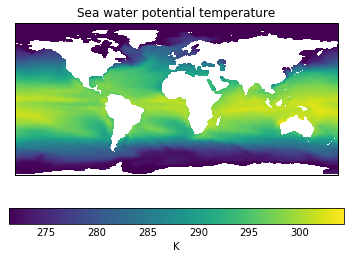

In [167]:
qplt.pcolormesh(thetao_cube)
plt.show()

In [169]:
print(numpy.ma.average(thetao_cube.data, weights=areacello_cube.data))
print(numpy.ma.sum(thetao_cube.data * areacello_cube.data))

290.79294
1.0503744e+17


In [147]:
thetao_cube.coord(axis='x').coord_system = iris.coord_systems.GeogCS(iris.fileformats.pp.EARTH_RADIUS)
thetao_cube.coord(axis='y').coord_system = iris.coord_systems.GeogCS(iris.fileformats.pp.EARTH_RADIUS)

tas_cube.coord(axis='x').coord_system = iris.coord_systems.GeogCS(iris.fileformats.pp.EARTH_RADIUS)
tas_cube.coord(axis='y').coord_system = iris.coord_systems.GeogCS(iris.fileformats.pp.EARTH_RADIUS)

regridded_cube = regrid_weighted_curvilinear_to_rectilinear(thetao_cube, area_cube.data, tas_cube)

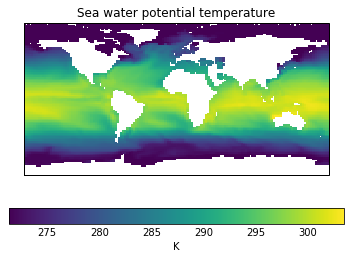

In [168]:
qplt.pcolormesh(regridded_cube)
plt.show()

In [170]:
print(numpy.ma.average(regridded_cube.data, weights=areacella_cube.data))
print(numpy.ma.sum(regridded_cube.data * areacella_cube.data))

290.646
1.110064e+17


## xarray and xESMF

In [150]:
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs

In [152]:
thetao_dset = xr.open_dataset(thetao_file)
thetao_da = thetao_dset['thetao'][0, 0, ::]
print(thetao_da)

<xarray.DataArray 'thetao' (j: 384, i: 320)>
[122880 values with dtype=float32]
Coordinates:
    time     object 1850-01-16 12:00:00
    lon      (j, i) float32 ...
    lat      (j, i) float32 ...
  * i        (i) int32 1 2 3 4 5 6 7 8 9 ... 312 313 314 315 316 317 318 319 320
  * j        (j) int32 1 2 3 4 5 6 7 8 9 ... 376 377 378 379 380 381 382 383 384
    lev      float64 0.0
Attributes:
    standard_name:     sea_water_potential_temperature
    long_name:         Sea Water Potential Temperature
    units:             K
    original_name:     templvl
    original_units:    degC
    cell_methods:      time: mean
    cell_measures:     area: areacello volume: volcello
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...


In [153]:
tas_dset = xr.open_dataset(tas_file)
tas_da = tas_dset['tas'][0, ::]
print(tas_da)

<xarray.DataArray 'tas' (lat: 96, lon: 144)>
array([[240.87465, 241.17218, 241.80669, ..., 241.16728, 240.50069, 240.45343],
       [243.62056, 242.80388, 242.72005, ..., 243.88705, 243.62401, 242.9797 ],
       [246.40518, 246.1459 , 245.69649, ..., 246.30771, 246.87439, 246.35362],
       ...,
       [240.18405, 239.9824 , 239.88286, ..., 240.60536, 240.49663, 240.36986],
       [238.46266, 238.36627, 238.2703 , ..., 238.64206, 238.59192, 238.53488],
       [237.19014, 237.20166, 237.20238, ..., 237.15863, 237.16963, 237.17471]],
      dtype=float32)
Coordinates:
    time     object 1850-01-16 12:00:00
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
    height   float64 ...
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    units:             K
    original_name:     TREFHT
    cell_methods:      time: mean
    cell_measu

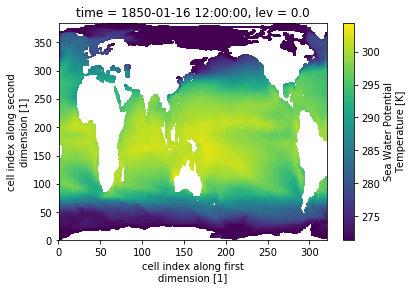

In [154]:
thetao_da.plot()
plt.show()

In [171]:
print(numpy.ma.average(thetao_da.to_masked_array(), weights=areacello_cube.data))
print(numpy.ma.sum(thetao_da.to_masked_array() * areacello_cube.data))

290.79294
1.0503744e+17


In [165]:
regridder = xe.Regridder(thetao_da, tas_da, 'bilinear')
regridded_da = regridder(thetao_da)
print(regridded_da)

Overwrite existing file: bilinear_384x320_96x144.nc 
 You can set reuse_weights=True to save computing time.
<xarray.DataArray 'thetao' (lat: 96, lon: 144)>
array([[  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       ...,
       [271.357246, 271.357364, 271.357487, ..., 271.356215, 271.356713,
        271.357102],
       [271.354521, 271.354468, 271.354381, ..., 271.354607, 271.354628,
        271.354571],
       [271.356388, 271.356388, 271.356388, ..., 271.356388, 271.356388,
        271.356388]])
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
Attributes:
    regrid_method:  bilinear


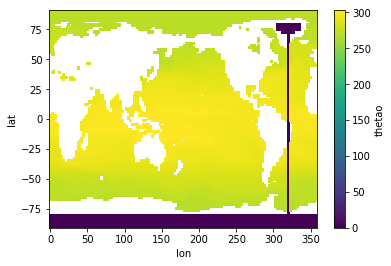

In [162]:
regridded_da.plot()
plt.show()

In [172]:
print(numpy.ma.average(regridded_da.to_masked_array(), weights=areacella_cube.data))
print(numpy.ma.sum(regridded_da.to_masked_array() * areacella_cube.data))

284.0711553578963
1.0070162059805696e+17
